# Lacrosse Predictors

Every year, in early May, the regular season winds down for college lacrosse and the playoffs begin. Unlike NCAA basketball and March Madness – where 66 teams are invited – only 18 teams are invited to the national tournament. For the 70 Division I teams competing for those spots, there are two ways to be selected. The first way is simple, secure an automatic qualification by winning your conference’s playoff tournament. There are ten conferences, leaving eight spots for other teams. These spots, known as “at-large” selections are up to the National Selection Committee to hand out. The committee utilizes the following criteria to select and seed teams:

> - Strength of schedule index.
> - Results of the RPI.
>   - Record against ranked teams 1-5; 6-10; 11-15; 16-20; 21+
>   -  Average RPI win (average RPI of all wins)
>   - Average RPI loss (average RPI of all losses)
> - Head-to-head competition:
>   - Results versus common opponents.
>   - Significant wins and losses (wins against teams ranked higher in the RPI and losses against teams ranked lower in the RPI).
>   - Locations of contests. 
> - Input from the regional advisory committee (comprised of lacrosse coaches from all AQ conferences). 

These criteria seem to place serios significance on this “RPI” ranking, but what even is it?

RPI, or rating percentage index, is a ranking of sports teams that aims to combine wins, losses, and strength of schedule. For any particular lacrosse team, it is calculated as:

- 25% the team's winning percentage
- 50% the team's opponents' average winning percentage
- 25% the team's opponents' opponents' winning percentages

The selection committee has traditionally used the RPI as a factor in its decisions for a variety of factors. For one thing, it is relatively easy to calculate. You do not need any advanced data or subjective metrics. All you need is teams wins and losses. Moreover, for a sport like college lacrosse, where each team only plays a small subset of the all the other teams, RPI does a good job considering teams that had harder and easier schedules. On top of that, RPI does typically align well with the “eye-test,” or how good you think a team is just by watching it. For those and other reasons, RPI has become an integral part of the selection process for the national college lacrosse tournament.

There are, however, several aspects of RPI to complain about. First off, it does not account for factors like margin of victory and home field advantage. Those are factors are known to important when predicting future outcomes. Additionally, not all conferences are equally competitive, so RPI can artificially inflate RPIs of “good” conferences and deflate RPIs of “bad” conferences.

With that in mind, I will be looking into the question of whether RPI is the best statistic to use for predicting outcomes of college lacrosse game, or if there is a better predictor out there that maybe the selection committee should be using. 

I will be pursuing two main avenues to try and find a better predictor. First, I will look at alternative ranking system such as ELO. ELO is rating system originally designed for ranking chess players, which you can read more about [here](https://en.wikipedia.org/wiki/Elo_rating_system). There are number of nuances to apply the ELO system to lacrosse, but those have mostly been taken care of by the lacrosse analytics site Lacrosse Reference. A detailed explanation of their lacrosse ELO system can be found [here](https://lacrossereference.com/2017/04/25/introducing-elo-college-lacrosse/), and I will just use their model for my comparison. The other two ranking systems I will look at are the coaches and media polls from USILA and Inside Lacrosse Respectively. Unlike RPI and ELO, these rankings are more subjective. They are not based comletely on stats, but factor in the "eye-test" as well. The "eye-test" is just judging teams based on observations you make watching them play, or generally any factor not easily represented by a stat. More specific information about USILA can be found [here](https://usila.org/sports/2015/10/6/GEN_1006154241.aspx).

Second, I will try to improve RPI itself using gradient decent to find better weights to apply to the three statistics it is based off. 25%, 50%, and 25% were originally arbitrarily chosen as “nice” values that seemed right. It begs to reason then that by tweaking those values with gradient decent we could create an RPI like stat that is a better predictor of the outcome of lacrosse games.

To begin the analysis, there are several datasets I need to create. I first need a dataset of all the college lacrosse games that have been played this season. I can only look at the current season because Lacrosse Reference only has the current season’s ELO rankings publicly available. Therefore, I will not be able to look at predictiveness for post-season games, as the post-season has not completed yet as I am writing this. That is not a problem though, since the regular season has completed, and is a larger dataset to analyze anyway.

To get the game data, I will be using the [daily scoreboard](https://stats.ncaa.org/contests/scoreboards?utf8=%E2%9C%93&sport_code=MLA&academic_year=&division=&game_date=&commit=Submit) on the NCAA Statistics website. The scoreboard has information on all the games played on a given day, including who played and who won. I was not able to find a public API, so to get the data I scraped day by day for every day of the lacrosse season. As I collect the data I am putting it in two dataframes. One dataframe serves as a schedule, saving the winner of each game, as well as which team was home and away. The other dataframe stores each game twice, once for each team. This will make it easier later to select the games a team played or the games where teams played against them, for instance. I can scrap day by day by just changing the date in the URL.


In [528]:
import requests as reqs
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [529]:
# helper function for removing parenthesis from the end of strings
def remove_record(str):
  try:
    return re.match(r'^(.*) \(', str).group(1)
  except AttributeError:
    return str

# some of the sites I am scrapping from will not respond unless the 
# user agent header is set in the html request
headers = {"User-Agent": "Lax-Stats-Bot"}

# Because this project is due 5-16-2022, I will not be able to include
# the last few tournament games in the dataset because they have not
# happened yet
season_dates = pd.date_range('2022-01-29', '2022-5-15')

In [530]:
# empty dataframes to store data in
df_games = pd.DataFrame()
df_schedule = pd.DataFrame()

for date in season_dates:
  # If there were no games on a particular day, trying to access the games table
  # will cause an error
  try: 
    # can just change the month and day parameters in the url to get a different day's games
    url = f'https://stats.ncaa.org/season_divisions/17822/scoreboards?utf8=%E2%9C%93&season_division_id=&game_date={date.month}%2F{date.day}%2F2022&conference_id=0&tournament_id=&commit=Submit'

    # make request and turn into dataframe
    req = reqs.get(url, headers=headers)
    games_table = pd.read_html(req.content)[0]

    # for each game in the games table, we need to 
    # further parse out the team names and other info.
    # each game is represented by 5 rows in the html table
    for i in range(0, len(games_table), 5):
      # if a game was cancled or postponed, it will throw an error when we try
      # to read in the score.
      # We are not worried about these games since you cannot check a prediction
      # for tham, so we will just throw them out
      try:
        # grab the 5 games that make up this game
        game = games_table.loc[i:i+5]

        # the team names are followed by the record, but we just
        # want to store the name with no record following it
        team1 = remove_record(game.loc[i, 'Teams.1'])
        team2 = remove_record(game.loc[i+3, 'Teams'])

        # some teams have a number ranking before the name
        # we are not interested in that so it is removed
        team1 = re.sub(r'^#\d ', '', team1)
        team2 = re.sub(r'^#\d ', '', team2)

        # read in the scores so we can tell who won
        team1_score = int(game.loc[i, 'Score.1'])
        team2_score = int(game.loc[i + 3, 'Teams.1'])

        # let win = 1 and loss = 0 to make manipulation easy later
        team1_outcome = 1 if team1_score > team2_score else 0
        team2_outcome = 1 if team2_score > team1_score else 0

        # put the data into dictionaries so it can be added to the
        # dataframes as rows
        game1 = {
          'date': date,
          'opponent': team2,
          'outcome': team1_outcome,
          'team': team1,
        }
        game2 = {
          'date': date,
          'opponent': team1,
          'outcome': team2_outcome,
          'team': team2,
        }

        schueled_game = {
          'home': team2,
          'away': team1,
          'date': date,
          'winner' : team1 if team1_score > team2_score else team2
        }

        df_schedule = df_schedule.append(schueled_game, ignore_index=True)

        df_games = df_games.append(game1, ignore_index=True)
        df_games = df_games.append(game2, ignore_index=True)
      except ValueError as err:
        pass
  
  except ValueError as err:
    print('No games on ' + date.isoformat()[:10])


No games on 2022-01-30
No games on 2022-01-31
No games on 2022-02-01
No games on 2022-02-02
No games on 2022-02-03
No games on 2022-02-07
No games on 2022-02-08
No games on 2022-02-10
No games on 2022-02-14
No games on 2022-02-17
No games on 2022-02-24
No games on 2022-03-03
No games on 2022-03-07
No games on 2022-03-17
No games on 2022-03-21
No games on 2022-03-23
No games on 2022-03-24
No games on 2022-03-25
No games on 2022-03-28
No games on 2022-03-30
No games on 2022-03-31
No games on 2022-04-04
No games on 2022-04-06
No games on 2022-04-13
No games on 2022-04-18
No games on 2022-04-25
No games on 2022-04-27
No games on 2022-05-02
No games on 2022-05-04
No games on 2022-05-09
No games on 2022-05-10
No games on 2022-05-12
No games on 2022-05-13


In [531]:
df_games.tail()

,date,opponent,outcome,team
1065,2022-05-15,Ohio St.,1.0,Cornell
1066,2022-05-15,Rutgers,0.0,Harvard
1067,2022-05-15,Harvard,1.0,Rutgers
1068,2022-05-15,Georgetown,1.0,Delaware
1069,2022-05-15,Delaware,0.0,Georgetown


In [532]:
df_schedule.tail()

,away,date,home,winner
530,Virginia,2022-05-14,Brown,Virginia
531,Saint Joseph's,2022-05-14,Yale,Yale
532,Ohio St.,2022-05-15,Cornell,Cornell
533,Harvard,2022-05-15,Rutgers,Rutgers
534,Delaware,2022-05-15,Georgetown,Delaware


Now that we have all of the games that were played, we have enough information to be able to calculate winning percentages, and thus RPI, for an arbitrary date.

Now we need to get the ELO rankings for teams throughout the season. Lacrosse Reference does have a [page](https://lacrossereference.com/stats/elo-d1-men/) with every team's current ELO, but it only has the up to date ranking. However, in order to use ELO to predict games I will need ELO for each team before every game. To get this I will need to look at each team's [individual page](https://lacrossereference.com/teams/a0038/) on Lacrosse Reference. The individual pages have a table that shows the graph with the change to ELO after each game. 

![Elo Table](img/elo-table.png)

I will just need to change this into a cumulative ranking after each game instead of the difference from game to game.

The individual team pages have a standard URL format, where the team to get the page for is identified by a 2 digit number at the end of the URL. By incrementing through all the teams I can scrape through every team's page.

In [533]:
# getting laxELO data

df_elo = pd.DataFrame()

for i in range(1, 76):
  try:
    req = reqs.get('https://lacrossereference.com/teams/a00%02d' % (i))
    soup = BeautifulSoup(req.content)

    # first figure out the name
    # the team name is in a div with a unique set of CSS classes so it can be easily puled out with beautiful soup
    team_str = soup.find(class_='col-12 font-24 bold').get_text()
    # that div does contain the teams record as well, so this regular expression isolates the name
    team = remove_record(team_str)

    # Scrapping ELO data
    # The ELO table is unfortunately not a HTML table, but we can grab the div by its unique ID
    elo_table_string = soup.find(id='elo_change_table').get_text()

    # the table lists a starting ELO, and then the change in ELO after each game
    # here we pull out the starting ELO by targeting its div
    starting_elo = int(soup.find_all(class_="no-padding dtop")[1].get_text())

    # thanks to beautiful soup the rows of the table are seperated by 2 new lines and the columns by a single new line
    # splitting on rows and columns then trhowing out rows/columns that do not contain data gives a 2D array that pandas can turn into a dataframe
    elo_table = pd.DataFrame([x.split('\n')[1:] for x in elo_table_string.split('\n\n')[3:-1]])\

    # name columns, drop unnecessary ones and add a team name column
    elo_table.columns = ['opponent', 'score', 'date', 'elo']
    elo_table.drop(['opponent', 'score'], axis=1,  inplace=True)
    elo_table['team'] = team

    # convert date and ELO columns to datetimes and numerics
    elo_table['date'] = pd.to_datetime(elo_table['date'] + ' 2022', format='%b %d %Y')
    elo_table['elo'] = pd.to_numeric(elo_table['elo'])

    # add row for initial elo on 1/28, they day befor the first game of the season
    initial = {
      'team': team,
      'elo': starting_elo,
      'date': pd.to_datetime('2022-01-28'),
    }
    df_elo = df_elo.append(initial, ignore_index=True)

    # Since the ELO column is the game to game change, need to go through it and update it to be an absolute ELO
    for index, row in elo_table.iterrows():
      prev = starting_elo if index == 0 else elo_table.loc[index - 1, 'elo']
      elo_table.loc[index, 'elo'] = elo_table.loc[index, 'elo'] + prev

    # add the 
    df_elo = df_elo.append(elo_table)
  
  except Exception as err:
    print('Problem fetching data from: "https://lacrossereference.com/teams/a00%02d"' % (i))


Problem fetching data from: "https://lacrossereference.com/teams/a0021"
Problem fetching data from: "https://lacrossereference.com/teams/a0024"


Manually checking those pages that did not have a team, they seem to be for teams that were Division I at some point, but are no longer playing in Division I any more.

In [534]:
df_elo.tail()

,date,elo,team
10,2022-04-09,1494.0,LIU
11,2022-04-16,1469.0,LIU
12,2022-04-23,1460.0,LIU
13,2022-04-30,1485.0,LIU
14,2022-05-05,1484.0,LIU


Now I have the ELO ranking for each team after every date in the season where it changed. There is a slight issue though. As you can see, the most recent ELO ranking of LIU is listed as 1484. At the time of writing this, the ELO listed by Lacrosse Reference on the [main ELO page](https://lacrossereference.com/stats/elo-d1-men/) is 1485. When manually looking through all the teams manually, I noticed that many of them are off from Lacrosse Reference's official rankings by a point or two. I believe this is because behind the scenes, Lacrosse Reference calculates ELO and ELO changes as decimal numbers, but when they display them on the website, they round them off to the nearest whole number. Over the course of a season the small rounding differences add up and cause some of my calculated ELOs to be slightly off. Because Lacrosse Reference does not have a public API, there is not really anything I can do to get around this issue. I am not worried about this effecting my analysis though. When you look at the ELO chart on Lacrosse Reference, you can see that it ranges from about 900 to nearly 2100, with most teams being seperated by more than a point or two. Hence, I am not worried about the small differences of my dataset from the authentic Lacrosse Reference ELO data to cause any signifigant problems.

For the USILA coaches ranking there is again to public API, so I will need to scrap the rankings from the individual pages they were posted in. The polls are posted every monday on a page like [this](https://usila.org/news/2022/5/9/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-may-9-1.aspx). The URLs are the same just with the date changed, so I can relatively easily scrap through all of them.

In [535]:
# USILA

# The URL for USILA polls uses the text version of the month instead of
# the number representation, so this dictionary just helps convert
# datetimes into the correct format
month_mappings = {
  2: 'feb',
  3: 'march',
  4: 'april',
  5: 'may'
}

# As of writing this, there are 14 weeks of polls published, starting every monday
# from February 7th to May 9th.
dates = [date for date in pd.date_range('2022-02-07', '2022-05-02', freq='7D')]

# Using the list of poll publish dates to generate the urls for the poll published
# on that date
urls = [f'https://usila.org/news/2022/{date.month}/{date.day}/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-{month_mappings[date.month]}-{date.day}.aspx' for date in dates]

# the very first ranking released was "preseason" ranking, and did not follow the typicall
# URL format, so I just add it manually, as well as the date it was published
# also for some reason the week 14 ranking is a different format as well
urls += ['https://usila.org/news/2022/2/1/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-preseason.aspx',
        'https://usila.org/news/2022/5/9/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-may-9-1.aspx']
dates += [pd.to_datetime('2022-02-01'), pd.to_datetime('2022-05-09')]

# create the empty dataframe to add the data to
df_usila = pd.DataFrame()


for url, date in zip(urls, dates):
  # get the page conent
  req = reqs.get(url, headers=headers)

  # turn the table into a dataframe
  # the ranking is the first table on the page, conveniently
  df = pd.read_html(req.content)[0]

  # renaming the columns to be what the actually represent but I am only 
  # interested in the teams and ranks, so I can just ignore the rest of the collumns
  df.columns = ['team', 'rank', 'record', 'points', 'last']
  df.drop(['record', 'points', 'last'], axis=1, inplace=True)

  # the team names have the records in the same string, so use my helper function
  # from earlier to remove it
  df['team'] = df['team'].apply(remove_record)

  # add the date as I will need that for analysis later
  df['date'] = date

  df_usila = df_usila.append(df)



In [536]:
df_usila.head()

,team,rank,date
0,Virginia,1,2022-02-07
1,Duke,2,2022-02-07
2,Maryland,3,2022-02-07
3,Georgetown,4,2022-02-07
4,North Carolina,4,2022-02-07


Now we have the complete coaches poll rankings from USILA. (I cannot believe somebody ranked Duke above Maryland going into the season)

I can get the media polls from inside lacrosse in a similar way, but as far as I can tell the URLs for the inside lacrosse pages are not predictable. Fortunately, on the main [Inside Lacrosse polls page](https://www.insidelacrosse.com/league/di/polls/2022), there is a navigation dropdown with the links to all of the polls. If I scrap that page first for the list of poll URLs, I can go through that list to get the poll for each week.

In [537]:
# Inside Lacrosse

# helper functino that takes the the week number a poll was published on
# and returns the date that many weeks after the intial list's date
# The preason ranking was published more than a week before the others,
# so it has a special case with its published date hard-coded
def get_date(str):
  preseason_date = '2022-01-24'
  first_week = '2022-02-07'
  if str == 'Preseason':
    return pd.to_datetime(preseason_date)
  weeks_past = int(str[-1])
  return pd.to_datetime(first_week) + pd.Timedelta(weeks_past, 'W')

# get the page containing the URLs to all the polls
poll_page = reqs.get('https://www.insidelacrosse.com/league/di/polls/2022', headers=headers)
soup = BeautifulSoup(poll_page.content)

# Us beautiful soup to get all the dropdown menus on the page
dropdown_menus = soup.find_all(class_='dropdown-menu')

# the poll URLs are in the second dropdown menu on the page
poll_pages = dropdown_menus[1]


# The URL stored in the navigatino dropdown is a relative path to another site on
# the server, so I will need to add the base path to the front to get absolute paths
base_url = 'https://www.insidelacrosse.com'

# create a list of tuples with the link to the page and the date 
urls_with_date = [((base_url + link['href']), get_date(link.text)) for link in poll_pages.contents]

# empty dataframe for results
df_ilax = pd.DataFrame()

for url, date in urls_with_date:
  poll_page = reqs.get(url, headers=headers)

  # read all the tables from the page
  rankings = pd.read_html(poll_page.content)

  # the ranking table is the first one on the page, and we can pull it out by name
  rankings = rankings[0]["Men's Division I Media Poll"]

  # the automatically generate dataframe has a lot of junk in it
  # instead of trying to clean it up, I will just pull out the info I
  # need from it into a new dataframe
  tidyer = pd.DataFrame()
  # need to remove the record from the team name string
  tidyer['team'] = rankings['Team'].apply(remove_record)
  # add the only two pieces of data I am interested in
  tidyer['rank'] = rankings['Rank']
  tidyer['date'] = date

  # add it to the results dataframe
  df_ilax = df_ilax.append(tidyer)


In [538]:
df_ilax.head()

,team,rank,date
0,Maryland,1,2022-02-28
1,Georgetown,2,2022-02-28
2,Penn,3,2022-02-28
3,Notre Dame,4,2022-02-28
4,Virginia,5,2022-02-28


That concludes the collection of all the data that will be necessary to analize the predictive power of different ranking systems. Because I collected all the data myself and validated it as I went, there is not much cleaning that needs to be done. The only issue is that some sources use slightly different versions of schools names to identify them. This will cause problems later when trying to match them up later on. To fix this I decided to use the version of the name used on the NCAA scoreboard as the standard version, and manually looked through the other sources for where the differences. I compiled those differences into a lookup table so I can go through each dataframe and replace the bad versions of names with the stanardized ones.


In [539]:
team_names = {
  'Army West Point': 'Army',
  'UAlbany': 'Albany', 
  'Albany (NY)': 'Albany',
  'Boston U.': 'Boston U',
  'Boston': 'Boston U',
  'Cleveland St.': 'Cleveland State',
  'Detroit Mercy': 'Detroit',
  'Loyola Maryland': 'Loyola',
  'Massachusetts': 'UMass',
  "Mount St. Mary’s": 'Mount St. Mary\'s',
  "Mount St Marys": 'Mount St. Mary\'s',
  'Ohio St.': 'Ohio State',
  'Penn St.': 'Penn State',
  'St. John\'s (NY)': 'St. John\'s',
  "St. John’s": "St. John\'s",
  'UMass Lowell': 'UMass-Lowell',
  'Saint Joseph`s': 'Saint Joseph\'s',
  'Saint Joseph’s': 'Saint Joseph\'s'
}

# standardize the team names so they are consitent across all dataframes
df_games = df_games.replace(team_names)
df_schedule = df_schedule.replace(team_names)
df_elo = df_elo.replace(team_names)
df_usila = df_usila.replace(team_names)
df_ilax = df_ilax.replace(team_names)

To start to explore the data I need to do some quick calculations first. In order to calculate RPI, you need to know each teams winning percentage at the data of each game. To make it easier later I will add teams winning percentages after each game they play to the games datarame.

In [540]:
# Add the winning percentage of each team after the game

for index, row in df_games.iterrows():
  date = row['date']
  team = row['team']

  # get all games played by this team by this date
  relevant_games = df_games[(df_games['team'] == team) & (df_games['date'] <= date)]
  
  # 
  if len(relevant_games) > 0:
    wp = relevant_games['outcome'].mean()
    df_games.at[index, 'wp'] = wp

df_games.tail(10)


,date,opponent,outcome,team,wp
1060,2022-05-14,Brown,1.0,Virginia,0.800000
1061,2022-05-14,Virginia,0.0,Brown,0.625000
1062,2022-05-14,Yale,0.0,Saint Joseph's,0.777778
1063,2022-05-14,Saint Joseph's,1.0,Yale,0.750000
1064,2022-05-15,Cornell,0.0,Ohio State,0.625000
1065,2022-05-15,Ohio State,1.0,Cornell,0.750000
1066,2022-05-15,Rutgers,0.0,Harvard,0.615385
1067,2022-05-15,Harvard,1.0,Rutgers,0.823529
1068,2022-05-15,Georgetown,1.0,Delaware,0.722222
1069,2022-05-15,Delaware,0.0,Georgetown,0.882353


To be able to calculate the prediction a ranking makes, I need to be able to easily get the ranking of a team on a particular date. Most of the rankings can be found with a lookup from the respective dataframes, but there are some specific cases for each ranking system.

 - ELO: because I had the ELO of each team going into the season, so there should always be an ELO available for every date in the season
 - USILA and Inside Lacrosse rankings: the raknings only cover the top 20 teams. If a team is not in the top 20, I will always return a ranking of 100, though this could really be any arbitrary value greater than 20.
 - Winning Percentage: This is just another lookup from the games dataframe. If a team has not playedany games than the winning percentage is considered t0 just be zero. The helper function also has an option for excluding a specific other team when calculating win percentage, since this is required for calculating RPI.
 - RPI: I actually need to calculate its three parts individually
    1. Winning Percentage: can be gotten with the other helper function
    2. Opponents Winning: First need to get the list of opponents, then call the winning percentage helper using the without option for the current team.
    3. Opponents-Opponents Winning Percentage: For each opponent, get the list of their opponenents, and than find the opponents-opponents winning percentage without the opponent using the other helper function

   The helper function just returns those three components without apply weights to them. This make it easier to test RPI systems with different weights later, as there will be no need to recalculate the three components.

In [545]:

def get_elo(team, date):
  try:
    # the relevant entries are the ones for this team before the
    # specified date
    rel = df_elo[(df_elo['team'] == team) & (df_elo['date'] < date)]
    # sort the relevant entries by date and grab the most recent one
    # which is the bottom, because default sort is ascending
    return rel.sort_values('date').iloc[-1]['elo']
  except IndexError:
    # if there were no relevant entries, trying to get one causes
    # a problem, so just return and ELO of 0
    print(f'{team} could not be found')
    return 0

def get_usila(team, date):
  try:
    rel = df_usila[(df_usila['team'] == team) & (df_usila['date'] < date)]
    return rel.sort_values('date').iloc[-1]['rank']
  except IndexError:

    # default if unranked
    return 100

def get_ilax(team, date):
  try:
    rel = df_ilax[(df_ilax['team'] == team) & (df_ilax['date'] < date)]
    return rel.sort_values('date').iloc[-1]['rank']
  except IndexError:

    # default if unranked
    return 100

def get_wp(team, date, without=None):
  try:
    rel = df_games[(df_games['team'] == team) & (df_games['date'] < date) & (df_games['opponent'] !=  without)]
    # winning percentage is number of wins / games played
    # since wins are represented by 1 and loses are 0, getting
    # the number of wins is the same as the sum of the outcome column
    # To get the percentage you would need divide by the number of games,
    # which ends up being the same as taking the mean of the outcome column
    return rel['outcome'].mean()
  except IndexError:
    return 0

def get_rpi(team, date):
  # get all games played by the team beore the date
  rel_games = df_games[(df_games['team'] == team) & (df_games['date'] < date)]

  # get all the opponents played by this team
  opps = rel_games['opponent']

  # create an empty series with enough spots for all the opponents
  # to store that opponents-opponents winning percentage
  opps_opps_wp = pd.Series([0] * len(opps), dtype='float64')
  for index, opp in enumerate(opps):
    # get the opponents-opponents by selecting oponents column from the
    # opponents relevant games
    opps_opps = df_games[(df_games['team'] == opp) & (df_games['date'] < date)]['opponent']

    # for each opponent we need to get their winning percentage
    opps_opps = opps_opps.apply(lambda opp_opp: get_wp(opp_opp, date, without=opp))

    # save the average winning percentage or all of this opponents
    # opponents
    opps_opps_wp.loc[index] = opps_opps.mean()

  # the teams winning percentage
  wp = get_wp(team, date)

  # opponent winning percentage is the average of all the opponents
  # winning percentages
  opp_wp = opps.apply(lambda opp : get_wp(opp, date, without=team)).mean()

  # opponents-opponents winning percentage is the average of opponents
  # winning percentage for all opponents
  opp_opp_wp = opps_opps_wp.mean()

  # return a tuple of all three factors
  return wp, opp_wp, opp_opp_wp




With these helper functions in place, I can go through the schedule dataframe and for each game add whether each stat predicted it correctly or not. If the prediction is correct, I store that as a 1, and if the prediction is incorrect I store it as a 0.

In [550]:
# helper functino that takes a game from the schedule games
# and uses the other helper function to say whether or not
# each ranking predicted the game correctly
# stores that in a extra column of that games row
def add_predictions(game):
  # Get the details of this game
  winner = game['winner']
  team1, team2 = game['home'], game['away']
  date = game['date']

  # get all the rankings for both teams.
  elo1, elo2 = get_elo(team1, date), get_elo(team2, date)
  ilax1, ilax2 = get_ilax(team1, date), get_ilax(team2, date)
  usila1, usila2 = get_usila(team1, date), get_usila(team2, date)

  # get the raw RPI factors
  (a1, b1, c1), (a2, b2, c2) = get_rpi(team1, date), get_rpi(team2, date)

  # calculate the actual RPI
  rpi1, rpi2 = a1 * 0.25 + b1 * 0.50 + c1 * 0.25, a2 * 0.25 + b2 * 0.50 + c2 * 0.25

  # store the raw RPI factors for later
  game['home_rpi_factors'] = (a1, b1, c1)
  game['away_rpi_factors'] = (a2, b2, c2)

  # elo
  if elo1 > elo2 and winner == team1:
    game['elo'] = 1
  elif elo2 > elo1 and winner == team2:
    game['elo'] = 1
  else:
    game['elo'] = 0
  # rpi
  if rpi1 > rpi2 and winner == team1:
    game['rpi'] = 1
  elif rpi2 > rpi1 and winner == team2:
    game['rpi'] = 1
  else:
    game['rpi'] = 0
  # ilax
  if ilax1 < ilax2 and winner == team1:
    game['ilax'] = 1
  elif ilax2 < ilax1 and winner == team2:
    game['ilax'] = 1
  else:
    game['ilax'] = 0
  # usali
  if usila1 < usila2 and winner == team1:
    game['usila'] = 1
  elif usila2 < usila1 and winner == team2:
    game['usila'] = 1
  else:
    game['usila'] = 0
  # home team
  game['pred_home'] = 1 if winner == team1 else 0
  return game

# go through all the games and add the prediction columns
df_schedule = df_schedule.apply(add_predictions, axis=1)

In [551]:
df_schedule.tail()

,away,date,home,winner,home_rpi_factors,away_rpi_factors,elo,rpi,ilax,usila,pred_home
530,Virginia,2022-05-14,Brown,Virginia,"(0.6666666666666666, 0.6016930781636665, 0.549...","(0.7857142857142857, 0.5374072356215214, 0.559...",1,1,1,1,0
531,Saint Joseph's,2022-05-14,Yale,Yale,"(0.7333333333333333, 0.5913786213786215, 0.578...","(0.8235294117647058, 0.5005918101506337, 0.483...",1,1,1,1,1
532,Ohio State,2022-05-15,Cornell,Cornell,"(0.7333333333333333, 0.5697913197913197, 0.575...","(0.6666666666666666, 0.5656510156510156, 0.547...",1,1,1,1,1
533,Harvard,2022-05-15,Rutgers,Rutgers,"(0.8125, 0.5826236263736264, 0.5432945348247837)","(0.6666666666666666, 0.5579822954822955, 0.560...",1,1,1,1,1
534,Delaware,2022-05-15,Georgetown,Delaware,"(0.9375, 0.5559169996669997, 0.563598627743274)","(0.7058823529411765, 0.48985982299131087, 0.50...",0,0,0,0,0


We now have all the games for the season and whether or not they were predicted correctly by ELO, RPI, USILA, or Inside Lacrosse Rankings. For fun, I also added a column for predicting the home team wins every single time.

To explore what this looks like I am going to break the data up by weeks and plot the plot the proportion of games each ranking system predicted correctly over the course of the season. Weeks should be a reasonable size to chuck the data by since typically teams play one game a week.

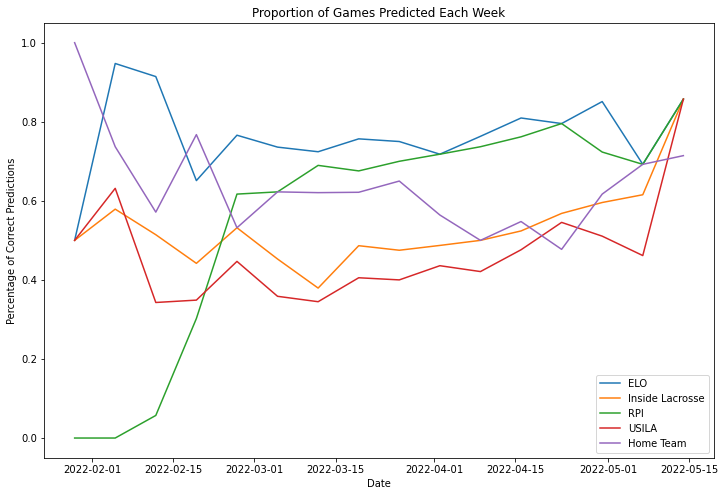

In [552]:
df_weekly_results = df_schedule.groupby(pd.Grouper(key='date', freq='7D')).mean()


fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Proportion of Games Predicted Each Week')
ax.set_ylabel('Percentage of Correct Predictions')
ax.set_xlabel('Date')

ax.plot(df_weekly_results.index, df_weekly_results[['elo', 'ilax', 'rpi', 'usila', 'pred_home']])
ax.legend(['ELO', 'Inside Lacrosse', 'RPI', 'USILA', 'Home Team'])

Looking at this chart a few things jump out. First of all, RPI starts out as a horrible predictor in the first couple weeks of the season. This does actually make sense though, as it relies on opponents winning percentage and opponents-opponents winning percentages. In the first few weeks of the season, teams have very few opponents, and their opponents could have even fewer opponents. That leads to the ranking being determined by very few datapoints and likely being swayed heavily by outliers. The NCAA does recognizee this, as they did not publish their official RPI rankings until March 27th this year, about halfway through the season.

Moreover, there seem to be unsual behavior at both ends of the graph, but that is just because the first couple and last couple weeks pictured have signifigantly fewer games in them. This can be seen by look at the counts of the groups.

In [555]:
df_schedule.groupby(pd.Grouper(key='date', freq='7D')).count()

,away,home,winner,home_rpi_factors,away_rpi_factors,elo,rpi,ilax,usila,pred_home
date,,,,,,,,,,
2022-01-29,2,2,2,2,2,2,2,2,2,2
2022-02-05,19,19,19,19,19,19,19,19,19,19
2022-02-12,35,35,35,35,35,35,35,35,35,35
2022-02-19,43,43,43,43,43,43,43,43,43,43
2022-02-26,47,47,47,47,47,47,47,47,47,47
2022-03-05,53,53,53,53,53,53,53,53,53,53
2022-03-12,29,29,29,29,29,29,29,29,29,29
2022-03-19,37,37,37,37,37,37,37,37,37,37
2022-03-26,40,40,40,40,40,40,40,40,40,40


Another observation from the chart is that just predicting games based off of who is the home team has the greatest varriation in success throughout the season. While this is not a prediction system I am analyzing, I thought it would be interesting to see how it compares to stats meant to predict. Interestingly, it does appear to predict more than half the games correct in the majority of weeks, which could indicate that home field advantage could be quite signifigant. Analyzing that further would be interesting, but is outside the scope of this project.

A final observation I made from the chart is that the subjective poll based rankings perform much worse than the objective rankings. That does make sense, as those rankings only care about the top 20, so they offer no predictive value to games between two teams that are not in the top 20. When comparing those rankings, it might therefore make sense to disregard games between two non-top 20 teams. It does not seem completely fair to throw out those games because after all, a good ranking system should be able to predict all the games. But for the sake of a more interesting comparison I will adjust the USILA and Inside Lacrosse rankings to only make a prediction on a game when at least one of the teams is ranked.

In [556]:
def adjust_predictions(row):
  # Get the details of this game
  winner = row['winner']
  team1, team2 = row['home'], row['away']
  date = row['date']

  # get all the rankings for both teams.
  ilax1, ilax2 = get_ilax(team1, date), get_ilax(team2, date)
  usila1, usila2 = get_usila(team1, date), get_usila(team2, date)

  # ilax
  if ilax1 < ilax2 and winner == team1:
    row['ilax_adj'] = 1
  elif ilax2 < ilax1 and winner == team2:
    row['ilax_adj'] = 1
  elif ilax1 == ilax2:
    row['ilax_adj'] = np.nan
  else:
    row['ilax_adj'] = 0
  # usali
  if usila1 < usila2 and winner == team1:
    row['usila_adj'] = 1
  elif usila2 < usila1 and winner == team2:
    row['usila_adj'] = 1
  elif usila1 == usila2:
    row['usila_adj'] = np.nan
  else:
    row['usila_adj'] = 0
  return row

df_schedule = df_schedule.apply(adjust_predictions, axis=1)

In [557]:
df_schedule.head()

,away,date,home,winner,home_rpi_factors,away_rpi_factors,elo,rpi,ilax,usila,pred_home,ilax_adj,usila_adj
0,Bellarmine,2022-01-29,Mercer,Mercer,"(nan, nan, nan)","(nan, nan, nan)",0,0,0,0,1,NaN,NaN
1,Robert Morris,2022-02-04,Duke,Duke,"(nan, nan, nan)","(nan, nan, nan)",1,0,1,1,1,1.0,1.0
2,Air Force,2022-02-05,Virginia,Virginia,"(nan, nan, nan)","(nan, nan, nan)",1,0,1,1,1,1.0,1.0
3,Bucknell,2022-02-05,Mercer,Bucknell,"(1.0, nan, nan)","(nan, nan, nan)",1,0,0,0,0,NaN,NaN
4,Mount St. Mary's,2022-02-05,Navy,Mount St. Mary's,"(nan, nan, nan)","(nan, nan, nan)",0,0,0,0,0,NaN,NaN


As you can see, in the adjusted columns for USILA and Inside Lacrosse, if neither team was ranking the prediction is given as NaN. The Pandas function mean() ignores NaNs by default when taking the average, so I can regroup and replot the data to see how these adjusted rankings compare to before.

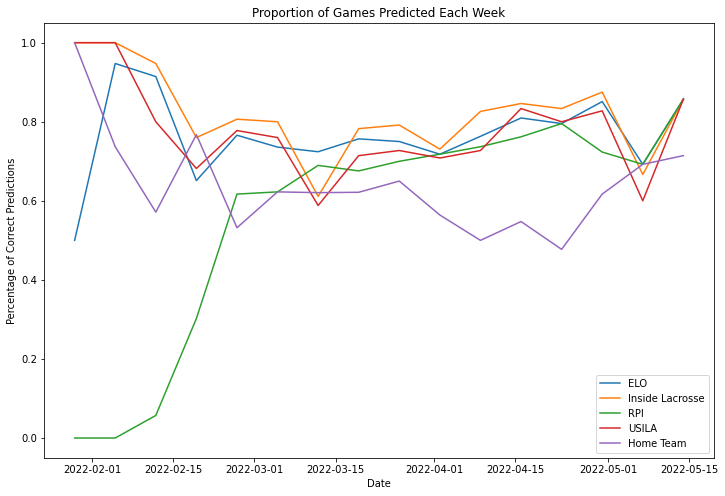

In [558]:
df_weekly_results = df_schedule.groupby(pd.Grouper(key='date', freq='7D')).mean()


fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Proportion of Games Predicted Each Week')
ax.set_ylabel('Percentage of Correct Predictions')
ax.set_xlabel('Date')

ax.plot(df_weekly_results.index, df_weekly_results[['elo', 'ilax_adj', 'rpi', 'usila_adj', 'pred_home']])
ax.legend(['ELO', 'Inside Lacrosse', 'RPI', 'USILA', 'Home Team'])

The chart shows that for games with at least one top 20 team, the subjective rankings have a roughly similar predictive ability to the objective rankings.

Looking at this chart, it does appear that RPI is the worst predictor of matchups besides always choosing the home team, but the variation from week to week makes it unsure if the other predictors are actually signifigantly better. To check for statistical signifigance, I will use a z-test for each of the other rankings. The null hypothesis will be that the ranking is predicts an equivalent proprtion of games correctly, and the alternative hypothesis will be that the ranking system out performs RPI. I will also set the signifigance value for these tests at 0.05.

When I perform these tests, I am only going to look at games after March 27th. I decided to do this because RPI as a predictor is dependent on having enough other games played to have information about the teams. The NCAA recognizes its weakness in the beginning of the season and does not publish RPI rankings until March 27th. I will follow the NCAAs lead and only look at RPI after March 28th.

First I will compare ELO to RPI

In [378]:
from statsmodels.stats.proportion import test_proportions_2indep

games_data = df_schedule[df_schedule['date'] >= '03-27-2022']

nobs = len(games_data)


test_proportions_2indep(games_data['elo'].sum(), nobs, games_data['rpi'].sum(), nobs, alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 0.9846276951593284
pvalue = 0.16240349032132895
compare = diff
method = agresti-caffo
diff = 0.03862660944206009
ratio = 1.0514285714285714
odds_ratio = 1.244548104956268
variance = 0.0015128825019504349
alternative = larger
value = 0
tuple = (0.9846276951593284, 0.16240349032132895)

The p-value is certainly greater than 0.05, so I cannot say that the increased accuracy of ELO over RPI for predicting games this season was statistically signifigant.

Looking at the USILA coaches poll:

In [566]:
adj = games_data.dropna(subset=['usila_adj'])

nobs = len(adj)

test_proportions_2indep(adj['usila_adj'].sum(), nobs, adj['rpi'].sum(), nobs, alternative='larger')


<class 'statsmodels.stats.base.HolderTuple'>
statistic = 0.13863062328260484
pvalue = 0.4448710215402436
compare = diff
method = agresti-caffo
diff = 0.006756756756756799
ratio = 1.008695652173913
odds_ratio = 1.040217391304348
variance = 0.0023125925925925927
alternative = larger
value = 0
tuple = (0.13863062328260484, 0.4448710215402436)

When comparing the USILA to the coaches poll to RPI, I removed all the games where both teams were not ranked. This makes the test less biased as we are comparing RPI's predictive ability only on games that the USILA ranking has an ability to make a prediction on. With that in mind the p-value is greater than 0.05, so I cannot say there is statistically signifigant difference in the performance of these two rankings as predictors of games.

Looking at the Inside Lacrosse Poll:

In [565]:
adj = games_data.dropna(subset=['ilax_adj'])

nobs = len(adj)

test_proportions_2indep(adj['ilax_adj'].sum(), nobs, adj['rpi'].sum(), nobs, alternative='larger')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 1.2395383196976264
pvalue = 0.10757310341587983
compare = diff
method = agresti-caffo
diff = 0.05696202531645578
ratio = 1.0743801652892564
odds_ratio = 1.4197166469893752
variance = 0.0020593261718750006
alternative = larger
value = 0
tuple = (1.2395383196976264, 0.10757310341587983)

Similarly, I only looked at the subset of games with at least one team ranked by Inside Lacrosse. And again, the p-value was not below 0.05. While Inside Lacrossee rankings did have lowest p-value, we cannot reject the null that Inside Lacrosse and RPI have the same predictive power.

Overall, no other predictor of Division I college lacrosse games I looked at is statistically better predictor of game outcomes than RPI. This surprised me, as in the chart it does look like the other ranking systems consitantly outperform RPI.

With that in mind, I will now look to improve the RPI statistic through gradient descent and finding weights for the three composing factors of RPI.

Because predicting outcomes of individual games is a discrete matter, I will have to make some modifications to typical gradient descent to use it effectively. For one thing, instead of a loss function, I will just use the accuracy of RPI with the given weights. And instead of minimizing it, I want to maximize it, so this will be more like gradient ascent. Also, since game predictions are discrete, there is no way to take a derivative or calculate a gradient. To avoid this issue I will use the gradient decent method from the class workbook, which uses an algebriac estimate of the gradient to perform gradient descent. The original for this technique is in [this notebook](https://github.com/cmsc320/lecture-code/blob/main/notebooks/gradient-descent.ipynb). Below I have made the necessary modifications to find better RPI weights.

In [567]:
# this is a helper function that actually figures out
# what the prediction for a game should be based on 
# the given RPI weights
def predict(game, weights):
    
    winner = game['winner']

    # get all the rankings for both teams.
    a1, b1, c1 = game['home_rpi_factors']
    a2, b2, c2 = game['away_rpi_factors']

    rpi1 = a1 * weights[0] + b1 * weights[1] + c1 * weights[2]
    rpi2 = a2 * weights[0] + b2 * weights[1] + c2 * weights[2]

    # rpi
    if rpi1 > rpi2 and winner == game['home']:
        return 1
    elif rpi2 > rpi1 and winner == game['away']:
        return 1
    else:
        return 0
  
# This is taking the place of a loss function
def rpi_accuracy(v):
    return games_data.apply(lambda game : predict(game, v), axis=1).mean()



# The following code in this block is from the class notebook

def estimate_partial(f, v, i, h):
    new_v = [val + (h if d == i else 0) for d, val in enumerate(v)]
    
    return (f(new_v) - f(v)) / h

# Getting the vector of partial derivatives is now just doing that for every index
def estimate_gradient(f, v, h):
    return [estimate_partial(f,v,i,h) for i in range(len(v))]

# A single step of Gradient Descent
# We assume that the input vector and the length of the gradient match!!!
# We also parameterize the function with a step-size
def single_step(vec, grad, ss):
    # multiply our gradient by the scalar step-size
    step = np.multiply(grad, ss)
    # add the resulting step vector to our input vector
    return vec + step

# random starting point
start = [.7, .9, .1]

# each 'epoch' is defined as the following:
#
# * estimate the gradient
# * take a step (opposite of the gradient)
v = start
for e in range(100):
    g = estimate_gradient(rpi_accuracy, v, 0.01)
    v = single_step(v, g, 0.01)

# We would hope that the resulting vector is close to 0 (because that's the minimum for our function)
print(v)
print(rpi_accuracy(v))
print(rpi_accuracy([0.25, 0.5, 0.25]))


[0.66566524 0.93433476 0.11287554]
0.7682403433476395
0.7510729613733905


As you can see gradient descent found that using weights of 0.666 for winning percentage, 0.9343 for opponents winning percentages, and 0.1129 for opponents opponents winning percentages resulted in accurately predicting more games correctly! One slight issue with the weighs is that the no longer total 1. This can easily be fixed by scalling them all down by the total value of all of them.

In [568]:
total = v[0] + v[1] + v[2]
best_weights = v / total

rpi_accuracy(best_weights)

0.7682403433476395

Now be have the best possible weights for calculating RPI with to predict the outcome of games with. We could see earlier that is it better than standard RPI, but is that difference signifigant?

It is time for another paired t-test to see if the two predictors do have signifigantly different accuracies. The null hypothesis is that both accuracies is the same, and the alternative hypothesis will be that the new weights are actually better at predicting games. The signifigance level for this test will be 0.05.

In [573]:
better_rpi = games_data.apply(lambda game : predict(game, best_weights), axis=1)

nobs = len(games_data)

test_proportions_2indep(better_rpi.sum(), nobs, games_data['rpi'].sum(), nobs, alternative='larger')


<class 'statsmodels.stats.base.HolderTuple'>
statistic = 0.4305435838085007
pvalue = 0.3334001348856306
compare = diff
method = agresti-caffo
diff = 0.01716738197424894
ratio = 1.022857142857143
odds_ratio = 1.0986243386243388
variance = 0.0015629677431782938
alternative = larger
value = 0
tuple = (0.4305435838085007, 0.3334001348856306)

The p-value is above the signifigance level of 0.05, so we cannot reject the null hypothesis. While the new weights for RPI were better, I cannot say that the difference is signifigant.

Another aspect of the new weights to consider is that they are likely overfitted to this season specifically. All of the training data was for this season, so it seams probably that if the two sets of weights were tested on a different season, they non standard ones would no longer be better.

In general, all of the analysis conducted in this tutorial could have benefitted by looking at multiple season. However, because of the difficulties of data collection, that was not in the scope of this tutorial.

# Conclusion

While there are many reasons to dislike RPI, statistically speaking, it holds up when looking at its value as a predictor of the outcomes of games. Perhaps it should not be such a prominent stat in the selection process for the tournament, but it also probably should not be ignored.